

# RNN for Time Series

RNNs are used for sequence modeling. This tutorial will look at a time series data to be modeled and predicted using RNNs.

In [ ]:
#
# Import Libraries
import numpy as np
import pandas as pd
%matplotlib  inline
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Read data first -  Use index_col = 'DATE' and 'parse_dates = True' as a parameter.
df = pd.read_csv('MRTSSM448USN.csv',index_col='DATE',parse_dates=True)

In [ ]:
# Print first few rows of data
df.head()

,MRTSSM448USN
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


Does the sales column has any name?

If no, set the name of the colum as 'Sales'.

In [ ]:
df.columns=['Sales']

Index(['Sales'], dtype='object')

Plot your data - Year vs Sales

<Axes: xlabel='DATE'>

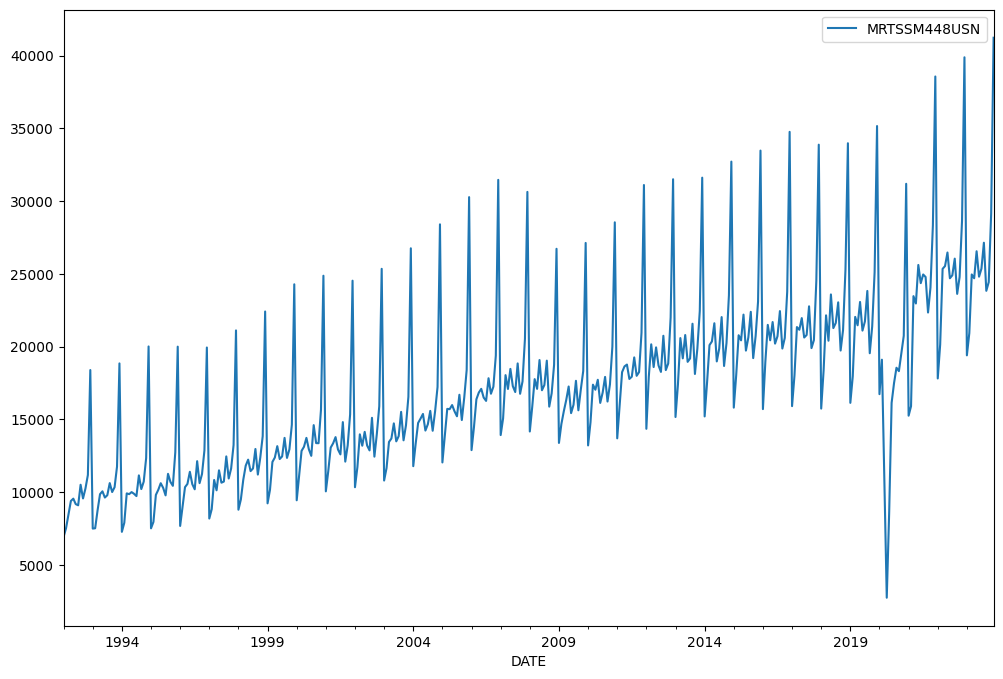

In [ ]:
# Your code to plot Year vs Sales. Use either matplot library of pandas dataframe.

df.plot(figsize=(12,8))

## Next we will do Train Test Split.

We will use last 1.5 year (18 month) samples for testing. Rest is for training.

In [ ]:
# Assign variable test size = 18

test_size =  18

In [ ]:
# Store length of data in variable length.
data_length=len(df)
data_length

384

In [ ]:
len(df)-18

366

In [ ]:
# store training size in variable train_size
#(Remember training size = total size  - test_size)

train_size = data_length - test_size
train_size

366

In [ ]:
#Assign the start of test index in data frame to variable test_index.  Remember, it is equal to the length of dataframe - test size

test_index = train_size

In [ ]:
# Store all data from 0 to test_index in variable train. Hint - Use df.iloc.

train = df.iloc[:test_index]
test = df.iloc[test_index:]


In [ ]:
# Print the size of the train data
print(train_size)

# Print the size of the test data
print(test_size)
# Print the train data
# print(train)
# Print the test data
print(len(train))

366
18
366


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)





In [ ]:
scaled_train = scaler.transform(train)


Now, we will find the indexes of the test data. Remember, these are the last 18 indexes in the pandas dataframe.

Next, we will separate train and test datasets.

## In Neural Networks, we need to Scale Data between 0-1

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

# We will use 12 months as input and then predict the next month out


In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
validator_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [ ]:
X, y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.11688819 0.13325142 0.15980677 0.18566402 0.19004803 0.17954875
 0.17734279 0.21671507 0.19046688 0.20948285 0.23553557 0.43680889]
Predict this y: 
 [[0.1326371]]


### Create the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
import tensorflow as tf

In [ ]:
# We're only using one feature in our time series
n_features = 1

# Define your own models.

Use 1. SimpleRNN, LSTM, or GRU neural network.

APIs:
https://keras.io/api/layers/recurrent_layers/

In [ ]:
#
# Your code to create your own model

#


import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the number of features
n_features = 1

# Define your TensorFlow model
model = Sequential([
    Dense(64, activation='relu', input_shape=(length, n_features)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer with 1 unit for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Print model summary
model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 12, 64)            128       
                                                                 
 dense_16 (Dense)            (None, 12, 32)            2080      
                                                                 
 dense_17 (Dense)            (None, 12, 1)             33        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [ ]:
validation_generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Your code to create an object early-stop.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

Now, fit your model.

In [ ]:
# Fit the model
history = model.fit(generator, epochs=50, batch_size=32, validation_data=(validator_generator), callbacks=[early_stopping])


Epoch 1/50
354/354 [==============================] - 2s 4ms/step - loss: 0.0191 - accuracy: 0.0028 - val_loss: 0.0687 - val_accuracy: 0.0000e+00
Epoch 2/50
354/354 [==============================] - 1s 3ms/step - loss: 0.0190 - accuracy: 0.0038 - val_loss: 0.0645 - val_accuracy: 0.0000e+00
Epoch 3/50
354/354 [==============================] - 1s 3ms/step - loss: 0.0189 - accuracy: 0.0042 - val_loss: 0.0668 - val_accuracy: 0.0000e+00
Epoch 4/50
354/354 [==============================] - 1s 4ms/step - loss: 0.0188 - accuracy: 0.0031 - val_loss: 0.0676 - val_accuracy: 0.0000e+00
Epoch 5/50
354/354 [==============================] - 1s 3ms/step - loss: 0.0183 - accuracy: 0.0040 - val_loss: 0.0642 - val_accuracy: 0.0000e+00
Epoch 6/50
354/354 [==============================] - 1s 3ms/step - loss: 0.0180 - accuracy: 0.0042 - val_loss: 0.0642 - val_accuracy: 0.0000e+00
Epoch 7/50
354/354 [==============================] - 1s 3ms/step - loss: 0.0179 - accuracy: 0.0024 - val_loss: 0.0723 - val

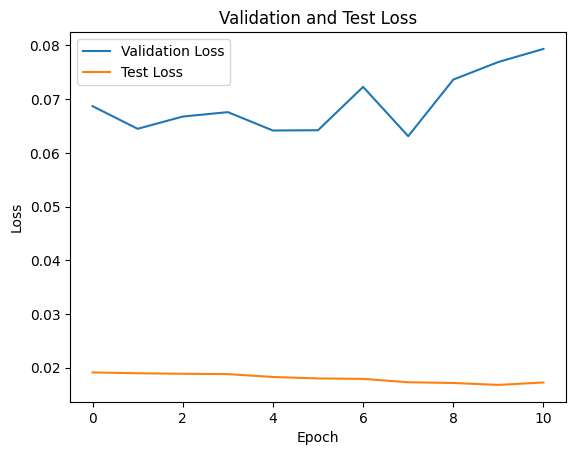

In [ ]:
# Get Losses from dataframe (hint - model.history.history)- See previous week tutorial.
# Plot losses in the dataframe.
# Extract losses from model history
losses = pd.DataFrame(model.history.history)

# Plot losses
plt.plot(losses['val_loss'], label='Validation Loss')
plt.plot(losses['loss'], label='Test Loss')
plt.title('Validation and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluate on Test Data

In [ ]:
first_eval_batch = scaled_train[-length:]

In [ ]:
n_input = 12
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)
scaled_test[0]

#### Try predicting the series!

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    # get prediction 1 time stamp ahead ([0] is for
    # grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

# Check and plot predictions

In [ ]:
# Print the test variable.

In [ ]:
# Your code to plot actual sales and predictions.

# Retrain and Forecasting

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data,
                                scaled_full_data, length=length, batch_size=1)

In [ ]:
#
# Use any neural network model based on RNN
#

In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):

    # get prediction 1 time stamp ahead ([0] is for  grabbing just the number instead of [array])


    # store prediction forecast.append(current_pred)

    # update batch to now include prediction and drop first value


In [ ]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [ ]:
df

In [ ]:
forecast_index = pd.date_range(start='2020-02-01',periods=periods,freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

In [ ]:
# Plot sales - Values in dataframe

In [ ]:
# Plot forecast - Values in forecast_df

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2021-01-01')

# Try the same example with a LSTM and GRU!
Hint: Use LSTM instead of SimpleRNN!